In [419]:
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks,argrelextrema
from datetime import date
from numpy.polynomial.polynomial import polyval
d = date.isoformat(date.today())
v = 0

In [347]:
def format_func(value, tick_number):
    return("{:.2E}".format(value))
def hc_fin_func(hc,hc_opp,hc_sym):
    if hc_sym == 'sym':
        hc_fin = (hc + hc_opp)/2
    elif hc_sym == 'antisym':
        hc_fin = (hc - hc_opp)/2
    elif hc_sym == 'bare':
        hc_fin = hc
    return(hc_fin)
def col_type_func(m_theta,case):
        #CASE == 0: THETA1=-THETA2 = THETA_NC
        #CASE == 1: THETA1= 0, THETA2 = +/- THETA_NC
        #CASE == 2: THETA1= 0/THETA_NC, THETA2 = THETA_NC/0
        #CASE == 3: THETA1 = +/-THETA_NC THETA2 = -/+THETA_NC
        #IN DEGREES
    if case == 0:
        theta_nc = (m_theta[0] - m_theta[1])/2
        theta_col = (m_theta[0] + m_theta[1])/2
    elif case == 1:
        theta_nc = m_theta[0] - m_theta[1]
        theta_col = m_theta[0]
    elif case == 2:
        theta_nc = m_theta[0] - m_theta[1]
        theta_col = m_theta[0]
    elif case == 3:
        theta_nc = (m_theta[0] - m_theta[1])/2
        theta_col = (m_theta[0] + m_theta[1])/2
    return(180./np.pi*theta_col,180./np.pi*theta_nc)
def setup_check(keyword,prefix,fname):
    pattern = keyword + "\s*=\s*['a-z]+|" + keyword + "\s*=\s*(\d+(.\d*)+(.\d*)E\+\d\d)|" + keyword + "\s*=\s*"
    with open(prefix + fname + '/setup.cfg','r') as fin:
        for num,line in enumerate(fin,1):
            s = re.search(pattern,line)
            if s!=None:
                if s.group(2)!=None:
                    val = float(s.group(1))
    return(val)


In [348]:
datesets = ["20190423","20190424","20190425","20190517"]
prefixsold = ["/Users/kipp/STB/output_jureca/" + d + "/" for d in datesets]
prefixs = ["/Data/ias-1/kipp/" + d + "/" for d in datesets]
save_prefix = "/Users/kipp/STB/weyl_figures/Weyl_figures/"
coltypes = ['col','noncol']
func_col_types = [1,0,2,3]
hc_syms = ['sym','antisym']
K_label = ["","$\Gamma$", "$K^{'}$", "K", "$\Gamma$"]
findbool = False
key = 'anticol_theta'
rotation = 'scancol'
rotation2 = 'scancolflip'
seedfname = "path_rel_G-K-Kprime"
save_strs = ["datafrom_" + ds for ds in datesets]
inputname = seedfname + '_' + key + '_' + rotation
inputname2 = seedfname + '_' + key + '_' + rotation2
files = 51
j = 0
peakexp = 3
symdict = {'sym':0,'antisym':files//2}
symstringdict = {'sym': 'symmetric','antisym':'antisymmetric'}
colthetalabeldict = {'col':'$\Theta_{col}$ [deg.]','noncol':'$\Theta_{nc}$ [deg.]'}
coltypesdict = dict(list(zip(datesets,func_col_types)))
symhclabeldict = {'sym':r'$\sigma_{sym,xy}$ [$\frac{e^2}{h}$]','antisym':r'$\sigma_{asym,xy}$ [$\frac{e^2}{h}$]','bare':r"$\sigma_{xy}$ [$\frac{e^2}{h}$]"}
labeldict = {'pwd':r"$\frac{\Delta\sigma}{\Delta\Theta}$",'peak':"$\sigma$"}
factordict = {'m_theta':180./np.pi,'lambda':1.,'t_so':1.}

In [349]:
peakslist = np.zeros((files,peakexp),dtype = int)
#angles = np.zeros(files,dtype = float)
def sigma_v_theta(dateset,inputname,inputname2,files,hc_sym,coltype,singlefile = False):
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    angles = np.zeros(files)
    if singlefile == True:
        hc_E = np.load(prefix + inputname + '/' + 'hall_cond_E.npy')
        hc_default = np.load(prefix + inputname + '/' + 'hall_cond.npy')
        hc_opp_default = np.load(prefix + inputname2 + '/' + 'hall_cond.npy')
        hc_fin_default = hc_fin_func(hc_default,hc_opp_default,hc_sym)
        m_theta = 180./np.pi*np.load(prefix + inputname + '/' + 'm_theta.npy')
        m_theta_opp = 180./np.pi*np.load(prefix + inputname2 + '/' + 'm_theta.npy')
        theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
        angles = theta_col
    else:
        hc_E = np.load(prefix + inputname + '_{:02}/'.format(symdict[hc_sym]) + 'hall_cond_E.npy')
        hc_default = np.load(prefix + inputname + '_{:02}/'.format(symdict[hc_sym]) + 'hall_cond.npy')
        hc_opp_default = np.load(prefix + inputname2 + '_{:02}/'.format(symdict[hc_sym]) + 'hall_cond.npy')
        hc_fin_default = hc_fin_func(hc_default,hc_opp_default,hc_sym)
        m_theta = 180./np.pi*np.load(prefix + inputname + '_{:02}/'.format(symdict[hc_sym]) + 'm_theta.npy')
        m_theta_opp = 180./np.pi*np.load(prefix + inputname2 + '_{:02}/'.format(symdict[hc_sym]) + 'm_theta.npy')
        theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
        angles[symdict[hc_sym]] = theta_col
    npoints = hc_default.shape[0]
    index = npoints
    prom = abs(max(hc_fin_default)/4)
    peaks, props = find_peaks(abs(hc_fin_default[:index]), prominence = prom,distance = npoints//10)#,distance = npoints/peakexp)
    relpeaks = np.sort(np.flip(peaks[np.argsort(abs(hc_fin_default[peaks]))]))
    numpeaks = peaks.shape[0]
    peakdist = (relpeaks[-1]-relpeaks[0])/(numpeaks-1)*0.9
    peakslist = np.tile(relpeaks,(files,1))
    peakvallist = np.tile(hc_fin_default[relpeaks],(files,1))
    if singlefile == True:
        return(relpeaks,hc_fin_default[relpeaks],angles)
    for j in range(files):
        hc = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
        hc_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
        hc_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
        m_theta = 180./np.pi*np.load(prefix + inputname + '_{:02}/'.format(j) + 'm_theta.npy')
        m_theta_opp = 180./np.pi*np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'm_theta.npy')
        '''if coltype == 'noncol':
            theta_diff = (m_theta-m_theta_opp)/2
        else:
            theta_diff = (m_theta+m_theta_opp)/2
        angles[j] = theta_diff[0]'''
        theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
        angles[j] = theta_col
        hc_fin = hc_fin_func(hc,hc_opp,hc_sym)
        peakvallist[j] = hc_fin[peakslist[j]]
        if findbool == True:
            npoints = hc.shape[0]
            index = npoints
            prom = abs(max(hc_fin)/4)
            peaks, props = find_peaks(abs(hc_fin[:index]), prominence = prom,distance = peakdist)#,width = 1)
            if peaks.shape[0]>=numpeaks:
                relpeaks = np.sort(np.flip(peaks[np.argsort(abs(hc_fin[peaks]))]))[:numpeaks]
            else:
                peakslist[j,:] = relpeaks
                peakvallist[j,:] = hc_fin[peakslist[j,:]]
    return(peakslist,peakvallist,angles)
            #JUST LEAVE IT WITH PEAKPOS FROM FIRST SET? THIS WOULD CORRESPOND TO FIXED ENERGY FOR EVERY SET
            #FABIANS IDEA: EXTRACT ENERGY FROM BANDSTRUCTURE (MIN MAX OF BANDS)

In [350]:
def key_collect(dateset,inputname,inputname2,files,key,search_pos):
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    if search_pos == 'output':
        val = factordict[key]*np.load(prefix + inputname + '_{:02}/'.format(0) + key + '.npy')
    elif search_pos == 'setup':
        val = setup_check(key,prefix,inputname + '_{:02}/'.format(0))
    val_arr = np.tile(val,(files,1))
    val_arr_opp = np.tile(val,(files,1))
    for j in range(files):
        if search_pos == 'output':
            val = factordict[key]*np.load(prefix + inputname + '_{:02}/'.format(j) + key + '.npy')
            val_opp = factordict[key]*np.load(prefix + inputname2 + '_{:02}/'.format(j) + key + '.npy')
        elif search_pos == 'setup':
            val = setup_check(key,prefix,inputname + '_{:02}/'.format(j))
            val_opp = setup_check(key,prefix,inputname2 + '_{:02}/'.format(j))
        val_arr[j] = val
        val_arr_opp[j] = val_opp
    return(val_arr,val_arr_opp)

In [351]:
def sigma_v_theta_plotter(dateset,inputname,inputname2,save_prefix,save_str,hc_sym,coltype,peakslist,peakvallist,angles,fitdeg,fitlog=True):
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    j = symdict[hc_sym]
    start = files//2 - files//10 - 1
    stop = files//2 + files//10
    mfs = 20
    delta = 10**(-10)
    fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True,sharex = "row",sharey = 'row')
    hc_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
    hc = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
    hc_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
    hc_fin = hc_fin_func(hc,hc_opp,hc_sym)
    fig.suptitle('Hall conductance ' + symstringdict[hc_sym] + ' part',fontsize = mfs)
    ax[0,0].plot(hc_E,hc_fin,'blue')
    ax[0,0].grid(True)
    ax[0,0].set_xlabel('Energy [eV]',fontsize = mfs)
    ax[0,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[0,0].tick_params(labelsize = mfs)
    ax[0,0].set_title("$\Theta_{col} = $" + "{:1.2f}".format(angles[j]),fontsize = mfs)
    ax[0,1].set_axis_off()
    ax[0,2].remove()
    ax[1,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[1,0].set_xlabel(colthetalabeldict[coltype],fontsize = mfs)
    
    axins = inset_axes(ax[0,1], width=2.6, height=1.8,loc = 'upper left')
    axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
    #axins.set_title('Spin Configuration')
    axins.set_xlim(-1.8,2.8)
    axins.set_ylim(-1.2,1.2)
    m_theta = np.load(prefix + inputname + '_{:02}/'.format(j) + 'm_theta.npy')
    m_theta_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'm_theta.npy')
    theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
    dx = np.sin(m_theta)
    dz = np.cos(m_theta)
    dx_opp = np.sin(m_theta_opp)
    dz_opp = np.cos(m_theta_opp)        
    axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
    axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
    axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
    axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
    ylims = ax[0,1].get_ylim()
    xlims = ax[0,1].get_xlim()
    for n in range(3):
        if fitlog == True:
            fitinx = angles[start:stop]
            fitiny = peakvallist[start:stop,n]
            p = np.polyfit(fitinx,fitiny,deg = fitdeg) 
            ax[1,n].plot(fitinx,yfit,'g',label = 'fit')
            yfit = polyval(fitinx,np.flip(p))
        hc_pwd = (peakvallist[:,n]-np.roll(peakvallist[:,n],1))/(angles[n]- np.roll(angles,1)[n])
        hc_pwd2 = (peakvallist[:,n]-np.roll(peakvallist[:,n],-1))/(angles[n]- np.roll(angles,-1)[n])
        hc_pwd = (hc_pwd+hc_pwd2)/2
        hc_pwd[[0,-1]] = hc_pwd[[1,-2]]
        ax[0,0].plot(hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]],'bo')
        if hc_fin[peakslist[j,n]]<0:
            vaval = "bottom"
            textpos = (hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]]+0.1*ylims[1])  
        elif hc_fin[peakslist[j,n]]>0:
            vaval = "top"            
            textpos = (hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]]-0.1*ylims[1])  
        an = ax[0,0].annotate("E = {:1.2f} eV".format(hc_E[peakslist[j,n]]), xy=(0., 0.),
                              xytext=textpos, textcoords="data",
                              va=vaval, ha="center", fontsize = mfs-6,
                              bbox=dict(boxstyle="round", fc="w")
                             ) 
        ax[1,n].grid(True)
        ax[1,n].xaxis.set_major_locator(plt.MultipleLocator(30))
        ax[1,n].tick_params(labelsize = mfs)
        #ax[1,n].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
        ax[1,n].plot(angles,peakvallist[:,n],'b',label = labeldict['peak'])
        ax[1,n].plot(angles,hc_pwd,'r',label = labeldict['pwd'])
        
        #ax[1,n].set_title(symhclabeldict[hc_sym] + " vs. " + colthetalabeldict[coltype] + " at $E = {:1.2f}$ eV".format(hc_E[peakslist[j,n]]))
        ax[1,n].set_title("$E = {:1.2f}$ eV".format(hc_E[peakslist[j,n]]),fontsize = mfs)
        ax[1,n].legend(loc = 'best',fontsize = mfs)
    lmda = setup_check('lambda',prefix,inputname + "_{:02}".format(j))
    t_so = setup_check('t_so',prefix,inputname + "_{:02}".format(j))
    temperature = setup_check('temperature',prefix,inputname + "_{:02}".format(j))
    thetastr = "$\Theta_{cant}$" + " = {0:1.2f} deg.".format(theta_nc)
    lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
    t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
    temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
    textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
    ax[0,1].text(xlims[0], ylims[0], textstr,size = 18,
        horizontalalignment='left',
        verticalalignment='bottom')

    if save_str == None:
        with PdfPages(save_prefix + d + '_' + str(v) + '_' + dateset + '_' + coltype + '_' + hc_sym + '_sigmatrend.pdf') as pdf:
            pdf.savefig(fig)
    else:
        with PdfPages(save_prefix + d + '_' + str(v) + '_' + save_str + '_' + coltype + '_' + hc_sym + '_sigmatrend.pdf') as pdf:
            pdf.savefig(fig)
    plt.close(fig)

In [352]:
def sigma_zoom(dateset,inputname,inputname2,save_prefix,save_str,hc_sym,coltype,peakslist,peakvallist,angles,zoomparam):
    mfs = 22
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    j = symdict[hc_sym]
    hc_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
    hc = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
    hc_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
    E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'band_E.npy')
    DOS = np.load(prefix + inputname + '_{:02}/'.format(j) + 'DOS.npy')
    DOS_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'DOS_E.npy')
    print(DOS.shape)
    hc_fin = hc_fin_func(hc,hc_opp,hc_sym)
    npoints = hc.shape[0]
    npoints_E = E.shape[1]
    K = np.arange(npoints_E)
    rangearr = np.zeros((2,peakslist.shape[1]),dtype = int)
    rangearr[1,:] = peakslist[j] - npoints//(10*zoomparam)
    rangearr[0,:] = peakslist[j] + npoints//(10*zoomparam)
    rangearr = np.rot90(rangearr,-1)
    fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True)
    fig.suptitle('Hall conductance ' + symstringdict[hc_sym] + ' part,zoom',fontsize = mfs)
    ax[0,0].plot(hc_E,hc_fin,'blue')
    ax[0,0].grid(True)
    ax[0,0].set_xlabel('Energy [eV]',fontsize = mfs)
    ax[0,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[0,0].tick_params(labelsize = mfs)
    ax[0,0].set_title("$\Theta_{col} = $" + "{:1.2f}".format(angles[j]),fontsize = mfs)
    ax[1,0].set_xlabel('Energy [eV]',fontsize = mfs)
    ax[1,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[1,0].set_xlabel('Energy [eV]',fontsize = mfs)
    ax[1,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[0,2].set_ylabel('Energy [eV]',fontsize = mfs)
    ax[0,2].set_xlabel("k along path", fontsize = mfs)
    ax[0,2].tick_params(labelsize = mfs)
    ax[0,2].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
    ax[0,2].set_xticklabels(K_label)
    ax[0,2].set_title("Bandstructure",fontsize = mfs)
    ylims = ax[0,0].get_ylim()
    xlims = ax[0,0].get_xlim()
    axins = inset_axes(ax[0,1], width=2.6, height=1.8,loc = 'upper left')
    axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
    #axins.set_title('Spin Configuration')
    axins.set_xlim(-1.8,2.8)
    axins.set_ylim(-1.2,1.2)
    m_theta = np.load(prefix + inputname + '_{:02}/'.format(j) + 'm_theta.npy')
    m_theta_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'm_theta.npy')
    theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
    dx = np.sin(m_theta)
    dz = np.cos(m_theta)
    dx_opp = np.sin(m_theta_opp)
    dz_opp = np.cos(m_theta_opp)        
    axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
    axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
    axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
    axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
    ax[0,1].remove()
    for n in range(3):
        if n>(peakslist.shape[1]-1):
            ax[1,n].remove()
    for e in E:
        ax[0,2].plot(K,e)
    for n in range(peakslist.shape[1]):
        if hc_fin[peakslist[j,n]]<0:
            vaval = "bottom"
            textpos = (hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]]+0.1*ylims[1])  
        elif hc_fin[peakslist[j,n]]>0:
            vaval = "top"            
            textpos = (hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]]-0.1*ylims[1])  
        an = ax[0,0].annotate("E = {:1.2f} eV".format(hc_E[peakslist[j,n]]), xy=(0., 0.),
                              xytext=textpos, textcoords="data",
                              va=vaval, ha="center", fontsize = mfs-6,
                              bbox=dict(boxstyle="round", fc="w")
                             ) 
        ax[0,0].plot(hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]],'ro')
        ax[1,n].plot(hc_E[rangearr[n,0]:rangearr[n,1]],hc_fin[rangearr[n,0]:rangearr[n,1]],'b')
        ax[1,n].grid(True)
        ax[1,n].tick_params(labelsize = mfs)
        #ax[1,n].set_title("$E = {:1.2f}$ eV".format(hc_E[peakslist[j,n]]),fontsize = mfs)
        twinax = ax[1,n].twinx()
        twinax.plot(DOS_E[rangearr[n,0]:rangearr[n,1]],DOS[rangearr[n,0]:rangearr[n,1]],'r')
        twinax.set_ylabel("DOS",fontsize = mfs)
        twinax.tick_params(labelsize = mfs)
        
    with PdfPages(save_prefix + d + '_' + str(v) + '_' + dateset + '_' + coltype + '_' + hc_sym + '_sigmazoom.pdf') as pdf:
            pdf.savefig(fig)

In [353]:
def band_plotter(dateset,inputname,inputname2,save_prefix,save_str,hc_sym,coltype,peakslist,peakvallist,angles,zoomparam,singlefile = False):
    mfs = 22
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    print(inputname)
    
    if singlefile == True:
        hc_E = np.load(prefix + inputname + '/' + 'hall_cond_E.npy')
        hc = np.load(prefix + inputname + '/' + 'hall_cond.npy')
        hc_opp = np.load(prefix + inputname2 + '/' + 'hall_cond.npy')
        E = np.load(prefix + inputname + '/' + 'band_E.npy')
        DOS = np.load(prefix + inputname + '/' + 'DOS.npy')
        DOS_E = np.load(prefix + inputname + '/' + 'DOS_E.npy')    
        hc_asym = hc_fin_func(hc,hc_opp,"antisym")
        hc_sym = hc_fin_func(hc,hc_opp,"sym")
        npoints = hc.shape[0]
        npoints_E = E.shape[1]
        fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True,sharey = "all")
        fig.suptitle('Bandstructure and Hall conductance',fontsize = mfs)
        ax[0,0].grid(True)
        ax[0,0].set_ylabel('Energy [eV]',fontsize = mfs)
        ax[0,0].tick_params(labelsize = mfs)
        ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
        ax[0,0].set_xticklabels(K_label)

        ax[0,1].grid(True)
        ax[0,1].tick_params(labelsize = mfs)
        ax[0,1].set_xlabel("DOS",fontsize = mfs)

        dist = max(hc_asym)-min(hc_asym)
        step_asym = max(hc_asym)/4
        nsteps = 5
        exp = 0
        if dist<1:
            for power in range(10):
                y = dist*10**power
                if y>=1:
                    exp = power
                    ndist = np.round(dist*10**(exp)/nsteps,1)
                    step_asym = ndist*10**(-exp)
                    break
        dist = max(hc_sym)-min(hc_sym)
        step_sym = max(hc_sym)/5
        nsteps = 5
        exp = 0
        if dist<1:
            for power in range(10):
                y = dist*10**power
                if y>=1:
                    exp = power
                    ndist = np.round(dist*10**(exp)/nsteps,1)
                    step_sym = ndist*10**(-exp)
                    break
        
        dist = max(hc)-min(hc)
        step_bare = max(hc_sym)/5
        nsteps = 5
        exp = 0
        if dist<1:
            for power in range(10):
                y = dist*10**power
                if y>=1:
                    exp = power
                    ndist = np.round(dist*10**(exp)/nsteps,1)
                    step_bare = ndist*10**(-exp)
                    break
        ax[1,2].grid(True)
        ax[1,2].set_ylabel('Energy [eV]',fontsize = mfs)
        ax[1,2].set_xlabel(symhclabeldict["antisym"],fontsize = mfs)
        ax[1,2].tick_params(labelsize = mfs,rotation = 45)
        #ax[1,2].xaxis.set_major_locator(plt.MultipleLocator(step_asym))
        #ax[1,2].xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        ax[1,1].grid(True)
        ax[1,1].set_ylabel('Energy [eV]',fontsize = mfs)
        ax[1,1].set_xlabel(symhclabeldict["sym"],fontsize = mfs)
        ax[1,1].tick_params(labelsize = mfs,rotation = 45)
        #ax[1,1].xaxis.set_major_locator(plt.MultipleLocator(step_sym))
        #ax[1,1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
        
        ax[1,0].grid(True)
        ax[1,0].set_ylabel('Energy [eV]',fontsize = mfs)
        ax[1,0].set_xlabel(symhclabeldict["bare"],fontsize = mfs)
        ax[1,0].tick_params(labelsize = mfs,rotation = 45)
        #ax[1,0].xaxis.set_major_locator(plt.MultipleLocator(step_bare))
        #ax[1,0].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
        for e in E:
            ax[0,0].plot(e)
        ax[0,1].plot(DOS,DOS_E)
        ax[1,0].plot(hc,hc_E)
        ax[1,2].plot(hc_asym,hc_E)
        ax[1,1].plot(hc_sym,hc_E)
        
        ylims = ax[0,2].get_ylim()
        xlims = ax[0,2].get_xlim()
        
        axins = inset_axes(ax[0,2], width=2.6, height=1.8,loc = 'upper right')
        axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
        #axins.set_title('Spin Configuration')
        axins.set_xlim(-1.8,2.8)
        axins.set_ylim(-1.2,1.2)
        m_theta = np.load(prefix + inputname + '/' + 'm_theta.npy')
        m_theta_opp = np.load(prefix + inputname2 + '/' + 'm_theta.npy')
        theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
        dx = np.sin(m_theta)
        dz = np.cos(m_theta)
        dx_opp = np.sin(m_theta_opp)
        dz_opp = np.cos(m_theta_opp)        
        axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
        axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
        axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
        axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
        lmda = setup_check('lambda',prefix,inputname)
        t_so = setup_check('t_so',prefix,inputname)
        temperature = setup_check('temperature',prefix,inputname)
        thetastr = "$\Theta_{cant}$" + " = {:1.2f} deg.".format(theta_nc) + "\n$\Theta_{col}$" + " = {:1.2f} deg.".format(theta_col)
        lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
        t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
        temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
        textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
        ax[0,2].text(xlims[0], ylims[0], textstr,size = 18,
            horizontalalignment='left',
            verticalalignment='bottom')    
        ax[0,2].set_axis_off()
        #ax[1,2].remove()
        print(save_prefix)
        with PdfPages(save_prefix + str(d) + '_' + str(v) + '_' + dateset + '_' + coltype + '_' + 'bands.pdf') as pdf:
            pdf.savefig(fig)
        plt.close(fig)
    elif singlefile == False:
        for j in range(files):
            hc_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
            hc = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
            hc_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
            E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'band_E.npy')
            DOS = np.load(prefix + inputname + '_{:02}/'.format(j) + 'DOS.npy')
            DOS_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'DOS_E.npy')
            hc_asym = hc_fin_func(hc,hc_opp,"antisym")
            hc_sym = hc_fin_func(hc,hc_opp,"sym")
            npoints = hc.shape[0]
            npoints_E = E.shape[1]
            fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True,sharey = "all")
            fig.suptitle('Bandstructure and Hall conductance',fontsize = mfs)
            ax[0,0].grid(True)
            ax[0,0].set_ylabel('Energy [eV]',fontsize = mfs)
            ax[0,0].tick_params(labelsize = mfs)
            ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
            ax[0,0].set_xticklabels(K_label)

            ax[0,1].grid(True)
            ax[0,1].tick_params(labelsize = mfs)
            ax[0,1].set_xlabel("DOS",fontsize = mfs)

            dist = max(hc_asym)-min(hc_asym)
            step_asym = max(hc_asym)/4
            nsteps = 5
            exp = 0
            if dist<1:
                for power in range(10):
                    y = dist*10**power
                    if y>=1:
                        exp = power
                        ndist = np.round(dist*10**(exp)/nsteps,1)
                        step_asym = ndist*10**(-exp)
                        break
            dist = max(hc_sym)-min(hc_sym)
            step_sym = max(hc_sym)/5
            nsteps = 5
            exp = 0
            if dist<1:
                for power in range(10):
                    y = dist*10**power
                    if y>=1:
                        exp = power
                        ndist = np.round(dist*10**(exp)/nsteps,1)
                        step_sym = ndist*10**(-exp)
                        break
        
            dist = max(hc)-min(hc)
            step_bare = max(hc_sym)/5
            nsteps = 5
            exp = 0
            if dist<1:
                for power in range(10):
                    y = dist*10**power
                    if y>=1:
                        exp = power
                        ndist = np.round(dist*10**(exp)/nsteps,1)
                        step_bare = ndist*10**(-exp)
                        break
            ax[1,2].grid(True)
            ax[1,2].set_ylabel('Energy [eV]',fontsize = mfs)
            ax[1,2].set_xlabel(symhclabeldict["antisym"],fontsize = mfs)
            ax[1,2].tick_params(labelsize = mfs,rotation = 45)
            #ax[1,2].xaxis.set_major_locator(plt.MultipleLocator(step_asym))
            #ax[1,2].xaxis.set_major_formatter(plt.FuncFormatter(format_func))

            ax[1,1].grid(True)
            ax[1,1].set_ylabel('Energy [eV]',fontsize = mfs)
            ax[1,1].set_xlabel(symhclabeldict["sym"],fontsize = mfs)
            ax[1,1].tick_params(labelsize = mfs,rotation = 45)
        #ax[1,1].xaxis.set_major_locator(plt.MultipleLocator(step_sym))
        #ax[1,1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
        
            ax[1,0].grid(True)
            ax[1,0].set_ylabel('Energy [eV]',fontsize = mfs)
            ax[1,0].set_xlabel(symhclabeldict["bare"],fontsize = mfs)
            ax[1,0].tick_params(labelsize = mfs,rotation = 45)
        #ax[1,0].xaxis.set_major_locator(plt.MultipleLocator(step_bare))
        #ax[1,0].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
            for e in E:
                ax[0,0].plot(e)
            ax[0,1].plot(DOS,DOS_E)
            ax[1,0].plot(hc,hc_E)
            ax[1,2].plot(hc_asym,hc_E)
            ax[1,1].plot(hc_sym,hc_E)

            ylims = ax[0,2].get_ylim()
            xlims = ax[0,2].get_xlim()

            axins = inset_axes(ax[0,2], width=2.6, height=1.8,loc = 'upper right')
            axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
            #axins.set_title('Spin Configuration')
            axins.set_xlim(-1.8,2.8)
            axins.set_ylim(-1.2,1.2)
            m_theta = np.load(prefix + inputname + '_{:02}/'.format(j) + 'm_theta.npy')
            m_theta_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'm_theta.npy')
            theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
            dx = np.sin(m_theta)
            dz = np.cos(m_theta)
            dx_opp = np.sin(m_theta_opp)
            dz_opp = np.cos(m_theta_opp)        
            axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
            axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
            axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
            axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
            lmda = setup_check('lambda',prefix,inputname + "_{:02}".format(j))
            t_so = setup_check('t_so',prefix,inputname + "_{:02}".format(j))
            temperature = setup_check('temperature',prefix,inputname + "_{:02}".format(j))
            thetastr = "$\Theta_{cant}$" + " = {:1.2f} deg.".format(theta_nc) + "\n$\Theta_{col}$" + " = {:1.2f} deg.".format(theta_col)
            lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
            t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
            temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
            textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
            ax[0,2].text(xlims[0], ylims[0], textstr,size = 18,
                         horizontalalignment='left',
                         verticalalignment='bottom')    
            ax[0,2].set_axis_off()
        #ax[1,2].remove()
        
            with PdfPages(save_prefix + str(d) + '_' + str(v) + '_' + dateset + '_' + coltype + '_' + 'bands_{}.pdf'.format(j)) as pdf:
                pdf.savefig(fig)
            plt.close(fig)

In [354]:
def lambda_tso_plotter(dateset,inputname,inputname2,save_prefix,files,save_str,hc_sym,coltype,peakslist,peakvallist,angles):
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    j = symdict[hc_sym]
    start = files//2 - files//10 - 1
    stop = files//2 + files//10
    mfs = 20
    delta = 10**(-10)
    #fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True,sharex = "row",sharey = 'row')
    lmda,lmda_opp = key_collect(dateset,inputname,inputname2,files,'lambda',search_pos = 'setup')
    print(lmda)

In [356]:
zoomparam = 20
inputname = "path_rel_G-K-Kprime_anticol_theta_scananticol_00_lambda_00_t_so_"#02"
inputname2 = "path_rel_G-K-Kprime_anticol_theta_scananticolflip_00_lambda_00_t_so"#_02"
files = 6
for j in [3]:#[0,1,2]:
    peakslist,peakvallist,angles = sigma_v_theta(datesets[j],inputname,inputname2,files,hc_syms[1],coltypes[0])
    #sigma_zoom(datesets[j],inputname,inputname2,save_prefix,save_strs[j],hc_syms[1],coltypes[0],peakslist,peakvallist,angles,zoomparam)
    band_plotter(datesets[j],inputname,inputname2,save_prefix,save_strs[j],hc_syms[1],coltypes[0],peakslist,peakvallist,angles,zoomparam)
    sigma_v_theta_plotter(datesets[j],inputname,inputname2,save_prefix,save_strs[j],hc_syms[1],coltypes[0],peakslist,peakvallist,angles,fitdeg = 2,fitlog = False)

FileNotFoundError: [Errno 2] No such file or directory: '/Data/ias-1/kipp/20190517/path_rel_G-K-Kprime_anticol_theta_scananticol_00_lambda_00_t_so__25/hall_cond_E.npy'

In [10]:
rotation = 'scananticol'
rotation2 = 'scananticolflip'
inputname = seedfname + '_' + key + '_' + rotation + '_00_lambda_02_t_so'
inputname2 = seedfname + '_' + key + '_' + rotation2 + '_00_lambda_02_t_so'
lambda_tso_plotter(datesets[3],inputname,inputname2,save_prefix,5,save_strs[j],hc_syms[1],coltypes[0],peakslist,peakvallist,angles)
#band_plotter(datesets[3],inputname,inputname2,save_prefix,save_strs[j],hc_syms[1],coltypes[0],peakslist,peakvallist,angles,zoomparam)

NameError: name 'peakvallist' is not defined

In [328]:
inputname = "test_lambda_tso_col"
#inputname2 = "test_tso_lambdaflip"
inputname2 = inputname
zoomparam = 20
v = 0
#dateset,inputname,inputname2,save_prefix,save_str,hc_sym,coltype,peakslist,peakvallist,angles,zoomparam,singlefile = False
peakslist,peakvallist,angles = sigma_v_theta(datesets[3],inputname,inputname2,files,hc_syms[0],coltypes[1],singlefile = True)
band_plotter(datesets[3],inputname,inputname2,save_prefix,'',hc_syms[0],coltypes[1],peakslist,peakvallist,angles,zoomparam,singlefile = True)

test_lambda_tso_col
/Users/kipp/STB/weyl_figures/Weyl_figures/


In [242]:
type(d)

int

FileNotFoundError: [Errno 2] No such file or directory: '/Data/ias-1/kipp/20190517/test_lambda_tso_00_lambda_01_t_so_01/band_E.npy'

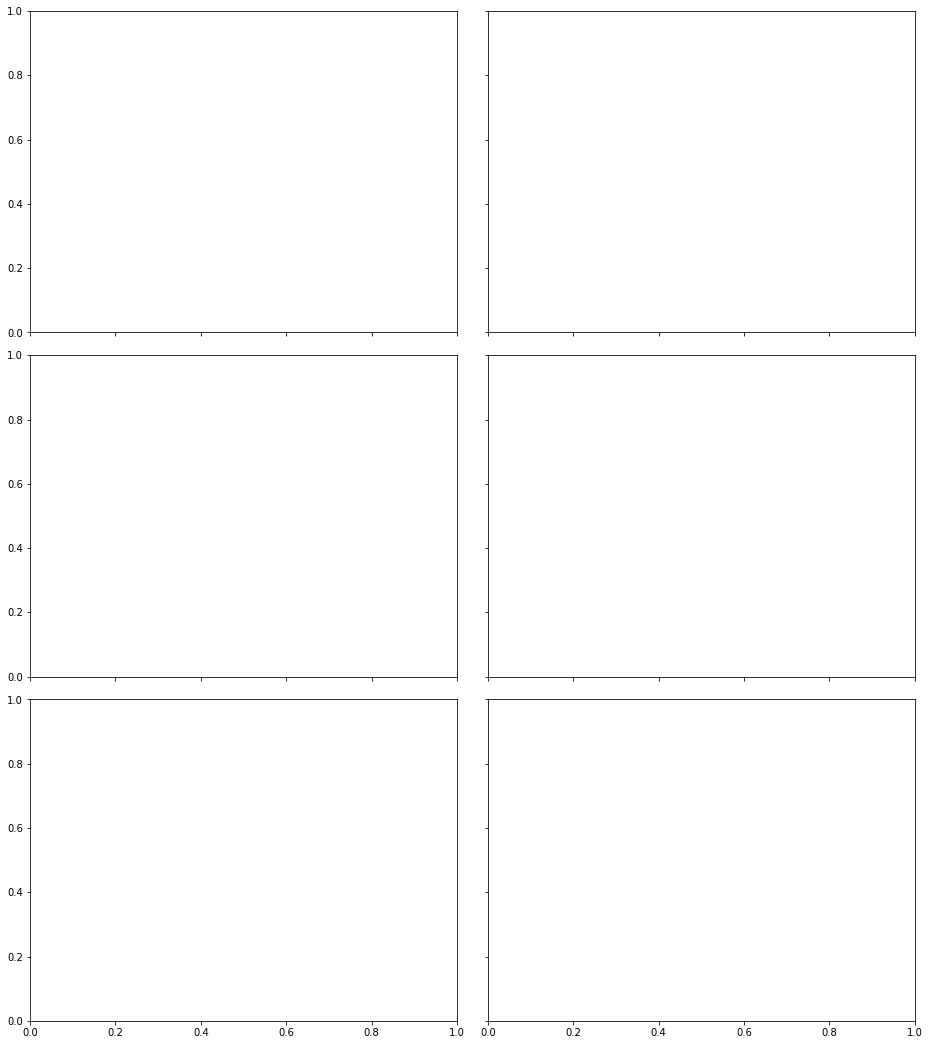

In [220]:
####BANDS DIFFERENCE####
files = 4
normmax = 2*files
from matplotlib import cm,colors,ticker
norm = colors.Normalize(vmin = 0, vmax = normmax)
#ax[0,0].plot(k,e,lw=0.5,color = cm.get_cmap('plasma')(norm(j)))
j_zero = 0   #THETA
k_zero = 0   #lAMBDA
l_zero = 2   #TSO
#inputname = "path_rel_G-K-Kprime_anticol_theta_scananticol"
#inputname2 = "path_rel_G-K-Kprime_anticol_theta_scananticolflip"
inputname = "test_lambda_tso"
inputname2 = "test_lambda_tsoflip"
#nputname = "test_tso_lambda"
#nputname2 = "test_tso_lambdaflip"
#E_collect = np.tile(E,(files,1))
K = np.arange(E.shape[1])
npoints_E = E.shape[1]
fig,ax = plt.subplots(nrows = 3,ncols = 2,figsize = (2*6.4,3*4.8),constrained_layout = True,sharex = "all",sharey = "row")
#fig.suptitle("Bandstructures")
axes = [ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
for j in range(0,files):
    ci = normmax//files
    m_theta = np.load(prefixs[3] + inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j,k,l) + 'm_theta.npy')
    m_theta_opp = np.load(prefixs[3] + inputname2 + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j,k,l) + 'm_theta.npy')
    theta_col,theta_nc = col_type_func(m_theta,coltypesdict[datesets[3]])
    E = np.load(prefixs[3] + inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j,k,l) + 'band_E.npy')
    E_opp = np.load(prefixs[3] + inputname2 + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j,k,l) + 'band_E.npy')
    E_diff = E - E_opp
    ax[0,0].plot(K,E[0],color = cm.get_cmap('gnuplot2')(norm(ci*j)),label = "$\Theta_{nc}$ = "+"{:1.2f} deg".format(theta_nc))
    ax[0,1].plot(K,E_opp[0],color = cm.get_cmap('gnuplot2')(norm(ci*j)),label = "$\Theta_{nc}$ = "+"{:1.2f} deg".format(theta_nc))
    ax[0,0].legend()
    ax[0,1].legend()
    for m in range(4):
        ci = normmax//4
        ax[0,0].plot(K,E[m],color = cm.get_cmap('gnuplot2')(norm(ci*j)))
        ax[0,1].plot(K,E_opp[m],color = cm.get_cmap('gnuplot2')(norm(ci*j)))
        axes[j].plot(K,E_diff[m],color = cm.get_cmap('gnuplot2')(norm(ci*m)),label = "Band {}".format(m))
        axes[j].legend()
        axes[j].set_title("$\Theta_{nc}$ = "+"{:1.2f} deg".format(theta_nc))

ax[2,0].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
ax[2,0].set_xticklabels(K_label)
ax[2,0].set_ylabel("Energy [eV]")
ax[0,0].set_title("$E(+\Theta_{nc})$")
ax[0,1].set_title("$E(-\Theta_{nc})$")
ax[0,0].legend()

ylims = ax[1,0].get_ylim()
xlims = ax[1,0].get_xlim()
'''
axins = inset_axes(ax[1,1], width=2.6, height=1.8,loc = 'upper right')
axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
axins.set_xlim(-1.8,2.8)
axins.set_ylim(-1.2,1.2)
m_theta = np.load(prefixs[3] + inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(1,0,0) + 'm_theta.npy')
m_theta_opp = np.load(prefixs[3] + inputname2 + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(1,0,0) + 'm_theta.npy')
print(m_theta,m_theta_opp)
theta_col,theta_nc = col_type_func(m_theta,coltypesdict[datesets[3]])
dx = np.sin(m_theta)
dz = np.cos(m_theta)
dx_opp = np.sin(m_theta_opp)
dz_opp = np.cos(m_theta_opp)        
axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
lmda = setup_check('lambda',prefixs[3],inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(1,0,0))
t_so = setup_check('t_so',prefixs[3],inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(1,0,0))
temperature = setup_check('temperature',prefixs[3],inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(1,0,0))
thetastr = "$\Theta_{cant}$" + " = {:1.2f} deg.".format(theta_nc) + "\n$\Theta_{col}$" + " = {:1.2f} deg.".format(theta_col)
lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
ax[1,1].text(xlims[0], ylims[0], textstr,size = 18,
             horizontalalignment='left',
             verticalalignment='bottom')    
ax[1,1].set_axis_off()
'''
#with PdfPages(save_prefix + d + '_' + str(v) + '_' + datesets[3] + '_' + '_' + 'bandscompare') as pdf:
#    pdf.savefig(fig)

2
(1,)
(4,)
(4,)
(1,)


'\naxins = inset_axes(ax[1,1], width=2.6, height=1.8,loc = \'upper right\')\naxins.tick_params(tick1On = False,labelleft=False, labelbottom=False)\naxins.set_xlim(-1.8,2.8)\naxins.set_ylim(-1.2,1.2)\nm_theta = np.load(prefixs[3] + inputname + \'/m_theta.npy\')\nm_theta_opp = np.load(prefixs[3] + inputname2 + \'/m_theta.npy\')\nprint(m_theta,m_theta_opp)\ntheta_col,theta_nc = col_type_func(m_theta,coltypesdict[datesets[3]])\ndx = np.sin(m_theta)\ndz = np.cos(m_theta)\ndx_opp = np.sin(m_theta_opp)\ndz_opp = np.cos(m_theta_opp)        \naxins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = \'blue\')\naxins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = \'blue\')\naxins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = \'red\')\naxins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = \'red\')\nlmda = setup_check(\'lambda\',prefixs[3],inputname + \'/\')\nt_so = setup_check(\'t_so\',prefixs[3],inpu

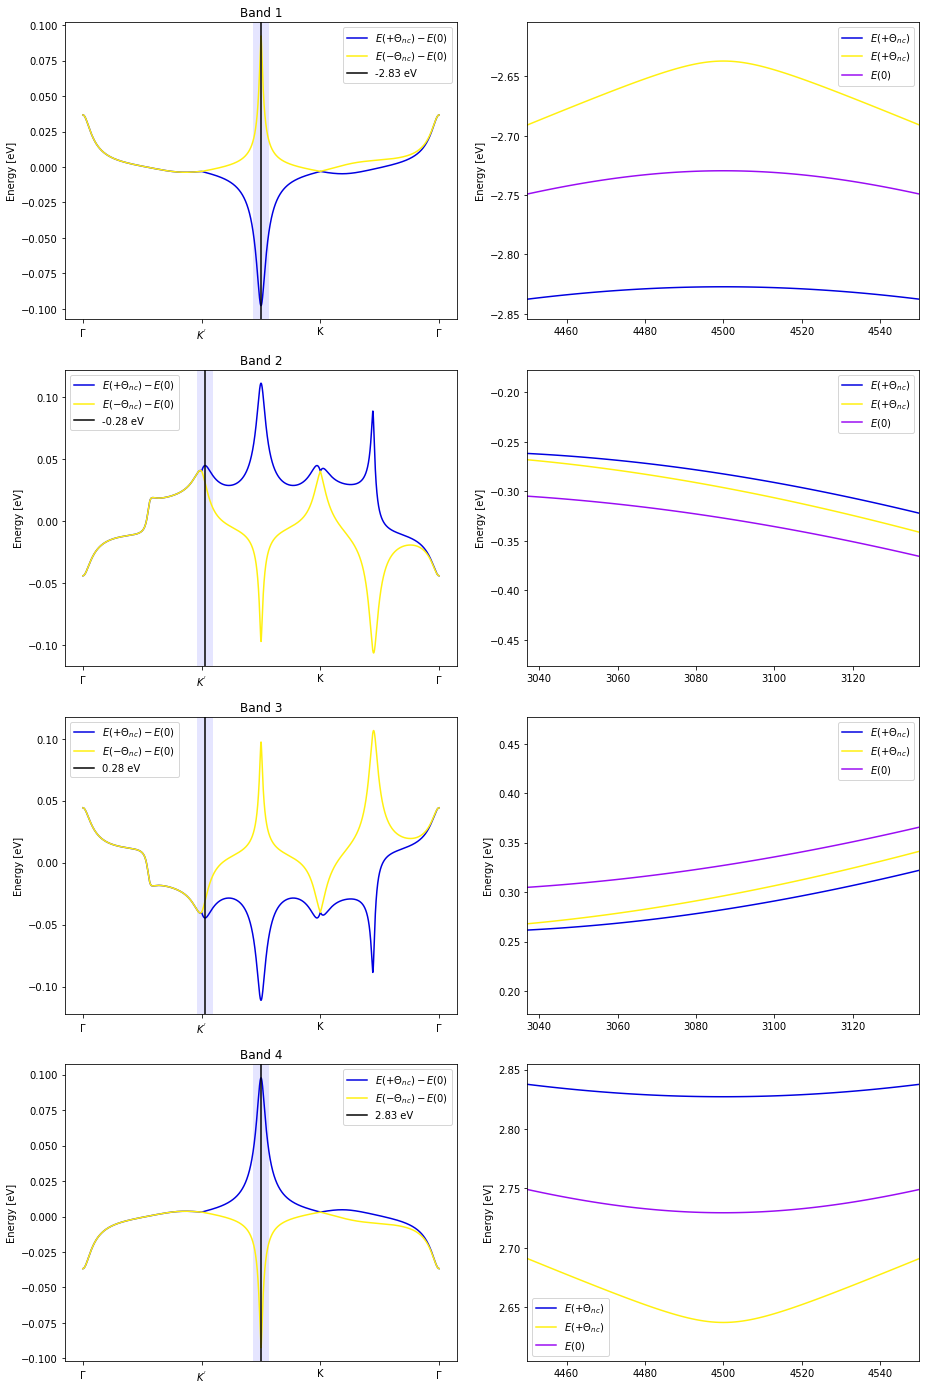

In [345]:
cnt = 0
files = 4
normmax = 2*files + 1
from matplotlib import cm,colors,ticker
norm = colors.Normalize(vmin = 0, vmax = normmax)
#ax[0,0].plot(k,e,lw=0.5,color = cm.get_cmap('plasma')(norm(j)))
j_zero = 0   #THETA
k_zero = 0   #lAMBDA
l_zero = 2   #TSO
inputname_null = "path_rel_G-K-Kprime_anticol_theta_scananticol_00_lambda_01_t_so_02"
inputname = "path_rel_G-K-Kprime_anticol_theta_scananticol_01_lambda_01_t_so_02"
inputname2 = "path_rel_G-K-Kprime_anticol_theta_scananticolflip_01_lambda_01_t_so_02"
#inputname = "test_lambda_tso"
#inputname2 = "test_lambda_tsoflip"
#inputname_null = "test_lambda_tso_col"
#inputname = "test_tso_lambda"
#inputname2 = "test_tso_lambdaflip"
#E_collect = np.tile(E,(files,1))
K = np.arange(E.shape[1])
npoints_E = E.shape[1]
fig,ax = plt.subplots(nrows = 4,ncols = 2,figsize = (2*6.4,4*4.8),constrained_layout = True)
#fig2,ax2 = plt.subplots(nrows = 2,ncols = 2,figsize = (2*6.4,2*4.8),constrained_layout = True,sharex = "all")
#fig.suptitle("Bandstructures")
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
axes2 = [ax2[0,0],ax2[0,1],ax2[1,0],ax2[1,1]]
for j in [0]:
    ci = normmax//files
    print(ci)
    m_theta = np.load(prefixs[3] + inputname + '/m_theta.npy')
    m_theta_opp = np.load(prefixs[3] + inputname2 + '/m_theta.npy')
    theta_col,theta_nc = col_type_func(m_theta,coltypesdict[datesets[3]])
    theta_col_opp,theta_nc_opp = col_type_func(m_theta_opp,coltypesdict[datesets[3]])
    E = np.load(prefixs[3] + inputname + '/band_E.npy')
    E_null = np.load(prefixs[3] + inputname_null + '/band_E.npy')
    E_opp = np.load(prefixs[3] + inputname2 + '/band_E.npy')
    E_diff = E - E_null
    E_diff_opp = E_opp - E_null
    #ax[0,0].plot(K,E[0],color = cm.get_cmap('gnuplot2')(norm(4)),label = "$\Theta_{nc}$ = "+"{:1.2f} deg".format(theta_nc))
    #ax[0,0].plot(K,E_null[0],color = cm.get_cmap('gnuplot2')(norm(ci*0)),label = "$\Theta_{nc}$ = "+"{:1.2f} deg".format(0))
    #ax[0,0].plot(K,E_opp[0],color = cm.get_cmap('gnuplot2')(norm(8)),label = "$\Theta_{nc}$ = "+"{:1.2f} deg".format(theta_nc_opp))
    #ax[0,0].legend()
    #ax[0,1].legend()
    for m in range(4):
        ci = normmax//4
        #ax[0,0].plot(K,E[m],color = cm.get_cmap('gnuplot2')(norm(ci*1)))
        #ax[0,0].plot(K,E_opp[m],color = cm.get_cmap('gnuplot2')(norm(ci*2)))
        #ax[0,0].plot(K,E_null[m],color = cm.get_cmap('gnuplot2')(norm(ci*0)))
        peaks, props = find_peaks(abs(E_diff[m]),prominence = 0.01)
        peaks_opp, props_opp = find_peaks(E_diff_opp[m])
        print(peaks.shape)
        if m < 2:
            offset = max(E[m])
        elif m >= 2:
            offset = min(E[m])            
        ax[m,0].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
        ax[m,0].set_xticklabels(K_label)
        ax[m,0].set_ylabel("Energy [eV]")
        ax[m,0].plot(K,E_diff[m],color = cm.get_cmap('gnuplot2')(norm(2)),label = "$E(+\Theta_{nc}) - E(0)$")
        ax[m,0].plot(K,E_diff_opp[m],color = cm.get_cmap('gnuplot2')(norm(8)),label = "$E(-\Theta_{nc}) - E(0)$")
        ax[m,0].set_title("Band {}".format(m+1))
        ax[m,1].plot(K,E[m],color = cm.get_cmap('gnuplot2')(norm(2)),label = "$E(+\Theta_{nc})$")
        ax[m,1].plot(K,E_opp[m],color = cm.get_cmap('gnuplot2')(norm(8)),label = "$E(+\Theta_{nc})$")
        ax[m,1].plot(K,E_null[m],color = cm.get_cmap('gnuplot2')(norm(4)),label = "$E(0)$")
        xticks = [peaks[0]-200,peaks[0]+200]
        yticks = ax[m,0].yaxis.get_majorticklocs() + E_null[m,peaks[0]]
        
        ax[m,0].axvspan(xmin = xticks[0], xmax = xticks[1],facecolor = "b",alpha = 0.1)
        ax[m,1].set_ylim(min(yticks),max(yticks))
        ax[m,1].set_xlim(peaks[0]-50,peaks[0]+50)
        ax[m,1].set_ylabel("Energy [eV]")
        ax[m,1].legend()
        #axes2[m].set_yticks(axes[m].yaxis.get_majorticklocs() + E[m,peaks[0]])
        cnt = 0
        ax[m,0].axvline(K[peaks[0]],color = cm.get_cmap('gnuplot2')(norm(0)),label = "{:1.2f} eV".format(E[m,peaks[0]]))
        #    cnt = cnt + 1
        #axes[m].set_yticks(axes[m].yaxis.get_majorticklocs())
        ax[m,0].legend()
        ax[m,1].legend()
        
        


#ax[0,0].set_title("$E(+\Theta_{nc})$")
#ax[0,1].set_title("$E(-\Theta_{nc})$")
#ax[0,0].legend()

ylims = ax[1,0].get_ylim()
xlims = ax[1,0].get_xlim()
'''
axins = inset_axes(ax[1,1], width=2.6, height=1.8,loc = 'upper right')
axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
axins.set_xlim(-1.8,2.8)
axins.set_ylim(-1.2,1.2)
m_theta = np.load(prefixs[3] + inputname + '/m_theta.npy')
m_theta_opp = np.load(prefixs[3] + inputname2 + '/m_theta.npy')
print(m_theta,m_theta_opp)
theta_col,theta_nc = col_type_func(m_theta,coltypesdict[datesets[3]])
dx = np.sin(m_theta)
dz = np.cos(m_theta)
dx_opp = np.sin(m_theta_opp)
dz_opp = np.cos(m_theta_opp)        
axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
lmda = setup_check('lambda',prefixs[3],inputname + '/')
t_so = setup_check('t_so',prefixs[3],inputname + '/')
temperature = setup_check('temperature',prefixs[3],inputname + '/')
thetastr = "$\Theta_{cant}$" + " = {:1.2f} deg.".format(theta_nc) + "\n$\Theta_{col}$" + " = {:1.2f} deg.".format(theta_col)
lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
ax[1,1].text(xlims[0], ylims[0], textstr,size = 18,
             horizontalalignment='left',
             verticalalignment='bottom')    
'''
#ax[1,1].set_axis_off()


(0.0, 1.0)
[ 0.5236 -0.5236] [-0.5236  0.5236]


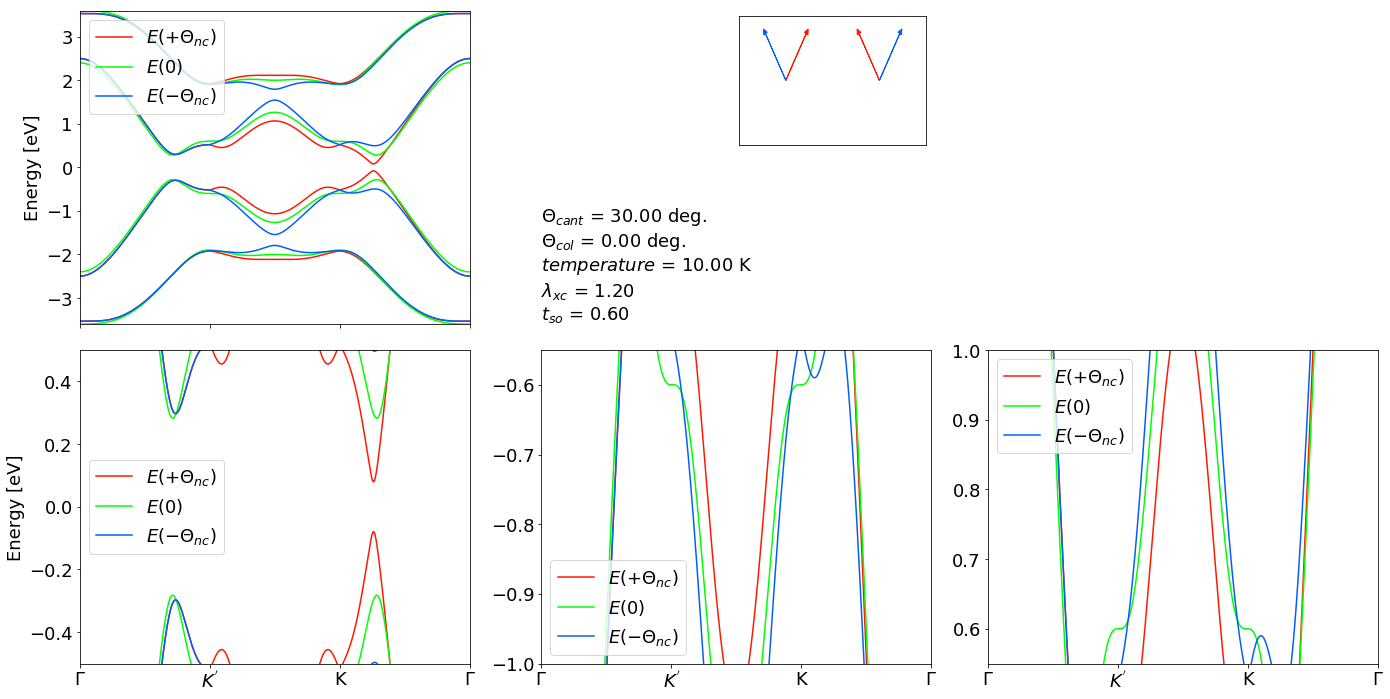

In [430]:
norm = colors.Normalize(vmin = 0, vmax = 20)
m,n,o = 1,8,14
#inputname = "test_lambda_tso"
#inputname2 = "test_lambda_tsoflip"
#inputname_null = "test_lambda_tso_col"
inputname_null = "path_rel_G-K-Kprime_anticol_theta_scananticol_00_lambda_02_t_so_01"
inputname = "path_rel_G-K-Kprime_anticol_theta_scananticol_01_lambda_02_t_so_01"
inputname2 = "path_rel_G-K-Kprime_anticol_theta_scananticolflip_01_lambda_02_t_so_01"
#colmap = 'gist_rainbow'
#inputname = "test_tso_lambda"
#inputname2 = "test_tso_lambdaflip"
#inputname_null = "test_tso_lambda_col"
E = np.load(prefixs[3] + inputname + '/band_E.npy')
E_null = np.load(prefixs[3] + inputname_null + '/band_E.npy')
E_opp = np.load(prefixs[3] + inputname2 + '/band_E.npy')
v = "1"
fig, ax = plt.subplots(nrows = 2, ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True,sharex = "all")
ax[1,0].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
ax[1,0].set_xticklabels(K_label)
ax[1,0].set_ylabel("Energy [eV]",fontsize = 18)
ax[0,0].set_ylabel("Energy [eV]",fontsize = 18)
for axes in [ax[0,0],ax[1,0],ax[1,1],ax[1,2]]:
    axes.tick_params(labelsize = 18)
    axes.plot(K,E[0],color =cm.get_cmap(colmap)(norm(m)),label = "$E(+\Theta_{nc})$")
    axes.plot(K,E_null[0],color =cm.get_cmap(colmap)(norm(n)),label = "$E(0)$")
    axes.plot(K,E_opp[0],color =cm.get_cmap(colmap)(norm(o)),label = "$E(-\Theta_{nc})$")
ax[0,0].legend(fontsize = 18)
ax[0,2].remove()
ax[0,1].set_axis_off()
for j in range(1,4):
    for axes in [ax[0,0],ax[1,0],ax[1,1],ax[1,2]]:
        axes.plot(K,E[j],color =cm.get_cmap(colmap)(norm(m)))
        axes.plot(K,E_null[j],color =cm.get_cmap(colmap)(norm(n)))
        axes.plot(K,E_opp[j],color =cm.get_cmap(colmap)(norm(o)))
ax[0,0].margins(x=0, y=-0.0)
ax[0,0].legend(fontsize = 18)
    #ax[1,0].plot(K,E[j],"r")
    #ax[1,0].plot(K,E_opp[j],"g")
    #ax[1,0].plot(K,E_null[j],"b")
ax[1,0].set_ylim(-0.5,0.5)
ax[1,0].legend(fontsize = 18)
    #ax[1,1].plot(K,E[j],"r")
    #ax[1,1].plot(K,E_opp[j],"g")
    #ax[1,1].plot(K,E_null[j],"b")
ax[1,1].set_ylim(-1.,-0.55)
ax[1,1].legend(fontsize = 18)
    #ax[1,2].plot(K,E[j],"r")
    #ax[1,2].plot(K,E_opp[j],"g")
    #ax[1,2].plot(K,E_null[j],"b")
ax[1,2].set_ylim(0.55,1.)
ax[1,2].legend(fontsize = 18)
ylims = ax[0,1].get_ylim()
xlims = ax[0,1].get_xlim()
print(ylims)
axins = inset_axes(ax[0,1], width=2.6, height=1.8,loc = 'upper right')
axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
axins.set_xlim(-1.8,2.8)
axins.set_ylim(-1.2,1.2)
m_theta = np.load(prefixs[3] + inputname + '/m_theta.npy')
m_theta_opp = np.load(prefixs[3] + inputname2 + '/m_theta.npy')
print(m_theta,m_theta_opp)
theta_col,theta_nc = col_type_func(m_theta,coltypesdict[datesets[3]])
dx = np.sin(m_theta)
dz = np.cos(m_theta)
dx_opp = np.sin(m_theta_opp)
dz_opp = np.cos(m_theta_opp)        
axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = cm.get_cmap(colmap)(norm(m)))
axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = cm.get_cmap(colmap)(norm(m)))
axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = cm.get_cmap(colmap)(norm(o)))
axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = cm.get_cmap(colmap)(norm(o)))

lmda = setup_check('lambda',prefixs[3],inputname + '/')
t_so = setup_check('t_so',prefixs[3],inputname + '/')
temperature = setup_check('temperature',prefixs[3],inputname + '/')
thetastr = "$\Theta_{cant}$" + " = {:1.2f} deg.".format(theta_nc) + "\n$\Theta_{col}$" + " = {:1.2f} deg.".format(theta_col)
lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
ax[0,1].text(xlims[0], ylims[0], textstr,size = 18,
             horizontalalignment='left',
             verticalalignment='bottom')
with PdfPages(save_prefix + d + '_' + str(v) + '_' + inputname + '_' + 'bandscompare') as pdf:
    pdf.savefig(fig)

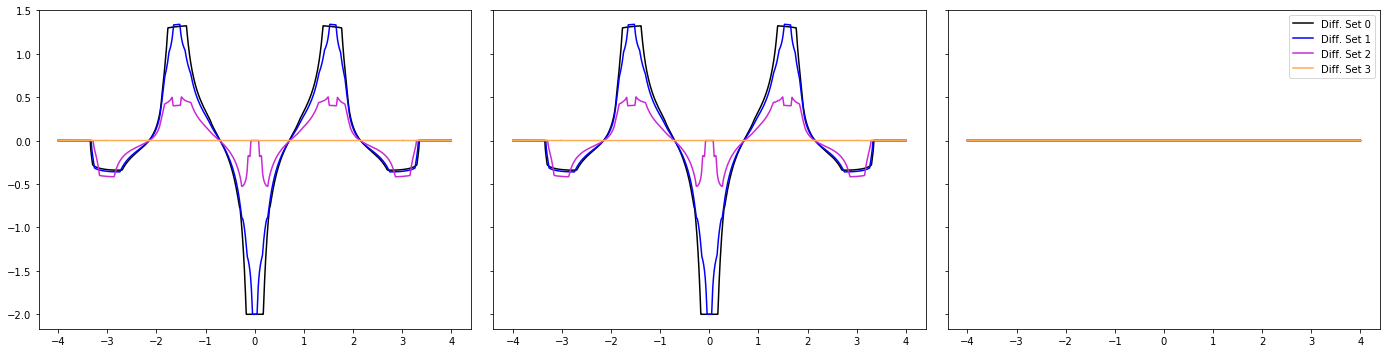

In [213]:
files = 4
from matplotlib import cm,colors,ticker
norm = colors.Normalize(vmin = 0, vmax = files)
#ax[0,0].plot(k,e,lw=0.5,color = cm.get_cmap('plasma')(norm(j)))
j_zero = 0   #THETA
k_zero = 1   #lAMBDA
l_zero = 1   #TSO
j = 0   #THETA
k = k_zero   #lAMBDA
l = l_zero   #TSO
inputname = "path_rel_G-K-Kprime_anticol_theta_scananticol"
inputname2 = "path_rel_G-K-Kprime_anticol_theta_scananticolflip"
#E_collect = np.tile(E,(files,1))
hc_E = np.load(prefixs[3] + inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j_zero,k_zero,l_zero) + 'hall_cond_E.npy')

npoints_hc = hc.shape[0]
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (3*6.4,4.8),constrained_layout = True,sharex = "all",sharey = "row")
for j in range(0,files):
    hc = np.load(prefixs[3] + inputname + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j,k,l) + 'hall_cond.npy')
    hc_opp = np.load(prefixs[3] + inputname2 + '_{0:02}_lambda_{1:02}_t_so_{2:02}/'.format(j,k,l) + 'hall_cond.npy')
    hc_diff = hc - hc_opp
    ax[0].plot(hc_E,hc,color = cm.get_cmap('gnuplot2')(norm(j)))
    ax[1].plot(hc_E,hc_opp,color = cm.get_cmap('gnuplot2')(norm(j)))
    ax[2].plot(hc_E,hc_diff,color = cm.get_cmap('gnuplot2')(norm(j)),label = "Diff. Set {}".format(j))
    ax[2].legend()
#ax[].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
#ax[2,0].set_xticklabels(K_label)

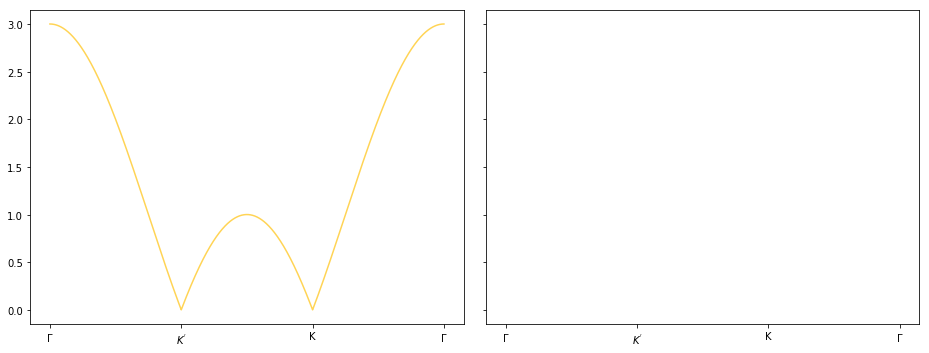

In [56]:
fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (2*6.4,4.8),constrained_layout = True,sharey = "all",sharex = "all")
ax[0].xaxis.set_major_locator(plt.MultipleLocator(npoints_E//3))
ax[0].set_xticklabels(K_label)
#for m in range(3):
    #ax[0].plot(E_collect[m:(m+4),:],color = cm.get_cmap('afmhot')(norm(m)))
for m in range(files):
    ax[0].plot(K,E_collect[5],color = cm.get_cmap('afmhot')(norm(2)))    

In [216]:
np.pi/180.*5.

0.08726646259971647

In [48]:
a.shape

(3, 10)